# Crimes in Vancouver from 2003-2017
* The aim of this project is to understand the history of [crimes in Vancouver](http://data.vancouver.ca/datacatalogue/crime-data-details.htm?)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter #Call formatter function to format tick values
import seaborn as sns
import datetime
import time 
%matplotlib inline

In [2]:
df = pd.read_csv('vancrime.csv')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 560741 entries, 0 to 560740
Data columns (total 10 columns):
TYPE             560741 non-null object
YEAR             560741 non-null int64
MONTH            560741 non-null int64
DAY              560741 non-null int64
HOUR             503868 non-null float64
MINUTE           503868 non-null float64
HUNDRED_BLOCK    560728 non-null object
NEIGHBOURHOOD    501541 non-null object
X                560741 non-null float64
Y                560741 non-null float64
dtypes: float64(4), int64(3), object(3)
memory usage: 42.8+ MB


In [4]:
df.tail()

,TYPE,YEAR,MONTH,DAY,HOUR,MINUTE,HUNDRED_BLOCK,NEIGHBOURHOOD,X,Y
560736,Theft from Vehicle,2018,4,16,13.0,55.0,5XX BEATTY ST,Central Business District,492110.50,5458716.35
560737,Mischief,2018,2,23,18.0,0.0,22XX ALMA ST,Kitsilano,486490.25,5457144.60
560738,Other Theft,2018,1,6,20.0,53.0,23XX W 41ST AVE,Arbutus Ridge,488360.09,5453558.41
560739,Theft from Vehicle,2018,4,15,22.0,0.0,53XX WINDSOR ST,Kensington-Cedar Cottage,493828.20,5453763.32
560740,Theft from Vehicle,2018,1,11,18.0,16.0,HUDSON ST / W 37TH AVE,Shaughnessy,490195.21,5453907.90


In [5]:
#Check for null values
df.isnull().sum()

TYPE                 0
YEAR                 0
MONTH                0
DAY                  0
HOUR             56873
MINUTE           56873
HUNDRED_BLOCK       13
NEIGHBOURHOOD    59200
X                    0
Y                    0
dtype: int64

In [6]:
#Drop all data that is of the 2018 year. We want to look at data from 2003-2017.
df = df[df.YEAR != 2018]

#Check if there are still any 2018 data
(df['YEAR']==2018).any()

False

In [7]:
#How many missing data now from 2003-2017
df.isnull().sum()

TYPE                 0
YEAR                 0
MONTH                0
DAY                  0
HOUR             55995
MINUTE           55995
HUNDRED_BLOCK       13
NEIGHBOURHOOD    58302
X                    0
Y                    0
dtype: int64

In [8]:
#Check to see how many null values in the year 2003
df[df.HOUR.isnull() & (df.YEAR == 2003)].count()

TYPE             3525
YEAR             3525
MONTH            3525
DAY              3525
HOUR                0
MINUTE              0
HUNDRED_BLOCK    3525
NEIGHBOURHOOD       0
X                3525
Y                3525
dtype: int64

In [9]:
#Dealing with missing values:
df['HOUR'].fillna(99, inplace = True)
df['MINUTE'].fillna(88, inplace = True)
df['NEIGHBOURHOOD'].fillna('N/A', inplace = True)
df['HUNDRED_BLOCK'].fillna('N/A', inplace = True)

In [10]:
#Check to see the kinds of unique crimes in the data
df.TYPE.unique()

array(['Theft from Vehicle', 'Offence Against a Person',
       'Break and Enter Commercial', 'Mischief',
       'Break and Enter Residential/Other', 'Theft of Bicycle',
       'Theft of Vehicle',
       'Vehicle Collision or Pedestrian Struck (with Fatality)',
       'Vehicle Collision or Pedestrian Struck (with Injury)',
       'Other Theft', 'Homicide'], dtype=object)

In [11]:
#Check distinct neighbourhoods in Vancovuer
df.NEIGHBOURHOOD.unique()

array(['Central Business District', 'Kitsilano', 'N/A',
       'Victoria-Fraserview', 'West End', 'Riley Park', 'Strathcona',
       'Kerrisdale', 'Dunbar-Southlands', 'Sunset', 'Arbutus Ridge',
       'Marpole', 'Shaughnessy', 'Killarney', 'Fairview', 'Mount Pleasant',
       'Grandview-Woodland', 'Renfrew-Collingwood', 'Hastings-Sunrise',
       'Kensington-Cedar Cottage', 'West Point Grey', 'South Cambie',
       'Stanley Park', 'Oakridge', 'Musqueam'], dtype=object)

In [12]:
#For visualization purposes later, we would like to know the day of the week.

#First, we convert the given data into a datetime format
df['DATE'] = pd.to_datetime({'year':df['YEAR'], 'month':df['MONTH'], 'day':df['DAY']})

#Now, we create a new column that presents the day of the week (0=Monday, 6=Sunday)
df['DAY_OF_WEEK'] = df['DATE'].dt.dayofweek

#Set index to DATE
df.index = pd.DatetimeIndex(df['DATE'])

# Explaratory Data Analysis

In [13]:
#Define robust function to automatically add annotated labels on bar plots.
#Inspiration from http://composition.al/blog/2015/11/29/a-better-way-to-add-labels-to-bar-charts-with-matplotlib/

def annotate_labels(ax, labels_list, **kwargs):
    """
    Function to automatically add labels on bar charts.
    It takes a plot axis, an ordered list of labels, and text kwargs.
    """
    # Get y-axis height to calculate label position from.
    (y_bottom, y_top) = ax.get_ylim()
    y_height = y_top - y_bottom
    
    rects = ax.patches

    for rect, label in zip(rects, labels_list):
        height = rect.get_height()
        p_height = (height / y_height) # Fraction of axis height taken up by this rectangle
        label_position = height + (y_height * 0.01)
        
        # If we can fit the label above the column, do that;
        # otherwise, put it inside the column (or else, change ylim)
        #if p_height > 0.95:
        #    label_position = height - (y_height * 0.05)
        #else:
        #    label_position = height + (y_height * 0.01)

        ax.text(rect.get_x() + rect.get_width()/2., label_position, label, kwargs)
    return None

In [14]:
def thousands_format(x, pos):
    """
    Args are the value and tick position. 
    Returns number of thousands with one decimal, and K in lieu of 3 zeros.
    """
    return '{:.0f}{}'.format(x * 1e-3, 'K') #old syntax: '%1.0fK' % (x * 1e-3)

In [15]:
df['TYPE'].value_counts().sort_index()

Break and Enter Commercial                                 34929
Break and Enter Residential/Other                          62027
Homicide                                                     227
Mischief                                                   73216
Offence Against a Person                                   55768
Other Theft                                                54807
Theft from Vehicle                                        179686
Theft of Bicycle                                           26938
Theft of Vehicle                                           39163
Vehicle Collision or Pedestrian Struck (with Fatality)       263
Vehicle Collision or Pedestrian Struck (with Injury)       22750
Name: TYPE, dtype: int64

## The frequency of the types of crimes in Vancouver from 2003-2017

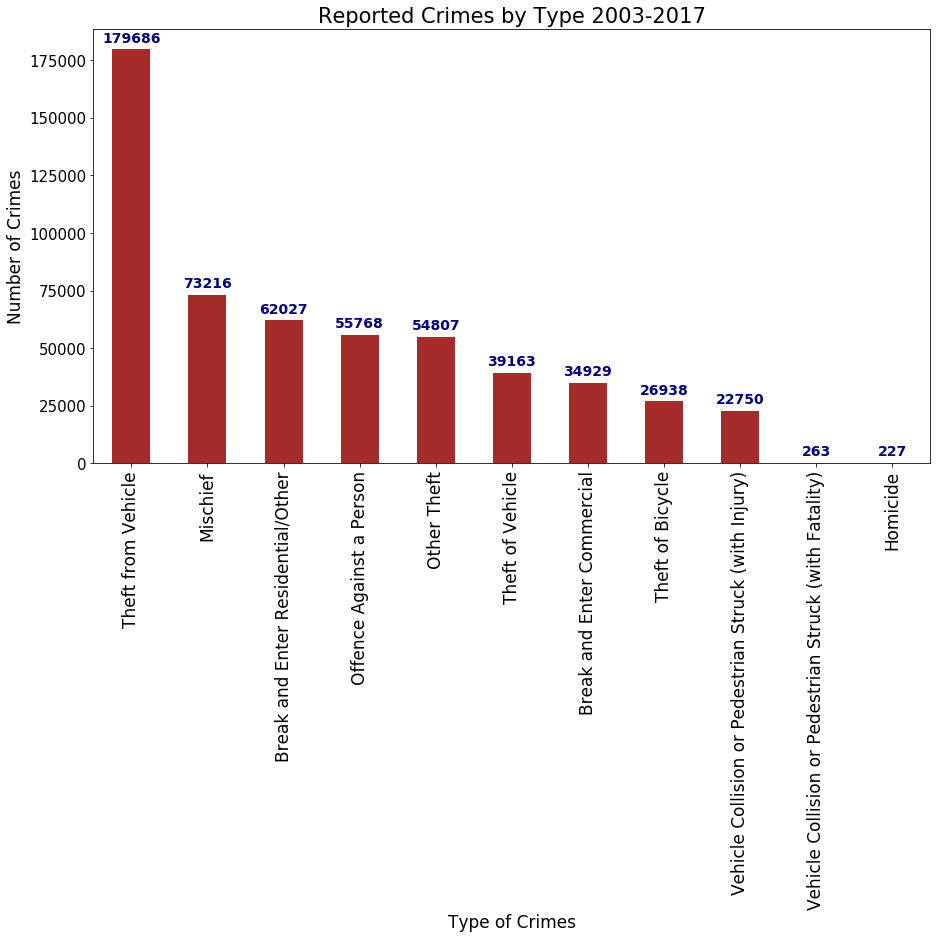

In [16]:
df_plt1 = df.groupby('TYPE').size().sort_values(ascending=False)

labels_list = df_plt1.values
kwargs = {'fontsize': 14, 'ha':'center', 'va': 'bottom', 'weight': 'bold', 'color': 'navy'}

ax = df_plt1.plot(kind='bar', figsize=(15,8),color='Brown')

annotate_labels(ax, labels_list, **kwargs)

plt.title('Reported Crimes by Type 2003-2017', fontsize=21)
plt.ylabel('Number of Crimes', fontsize=17)
plt.xlabel('Type of Crimes', fontsize=17)
plt.xticks(size = 17)
plt.yticks(size = 15)

plt.show()

In [17]:
weekday_labels = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
month_labels = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec', ]

## The distribution of crimes by hour, day, and month

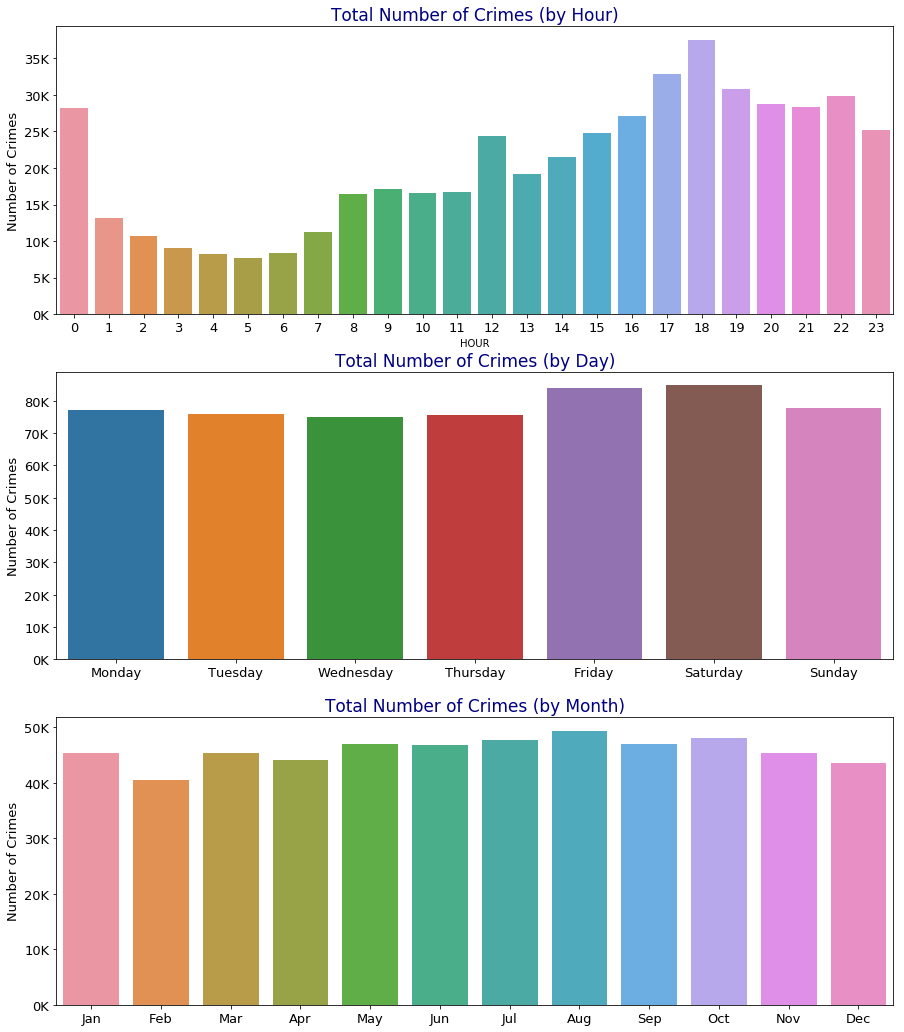

In [18]:
fig = plt.figure(figsize = (15,18))
formatter = FuncFormatter(thousands_format)


plt.subplot(3,1,1) #this plot could have a polar format, although I'm not sure it'd be a better viz.
ax1 = sns.countplot(df.HOUR, order = range(24))
ax1.yaxis.set_major_formatter(formatter)
plt.tick_params(labelsize=13)
plt.title('Total Number of Crimes (by Hour)', fontsize=17, color='navy')
plt.ylabel('Number of Crimes', fontsize=13)

plt.subplot(3,1,2)
ax2 = sns.countplot(df.DAY_OF_WEEK, order = range(7))
ax2.set_xticklabels(weekday_labels)
ax2.yaxis.set_major_formatter(formatter)
plt.tick_params(labelsize=13)
plt.xlabel('')
plt.title('Total Number of Crimes (by Day)', fontsize=17, color='navy')
#plt.xlabel('Day', fontsize=13)
plt.ylabel('Number of Crimes', fontsize=13)


plt.subplot(3,1,3)
ax2 = sns.countplot(df.MONTH)
ax2.set_xticklabels(month_labels)
ax2.yaxis.set_major_formatter(formatter)
plt.tick_params(labelsize=13)
plt.xlabel('')
plt.title('Total Number of Crimes (by Month)', fontsize=17, color='navy')
#plt.xlabel('Months', fontsize=13)
plt.ylabel('Number of Crimes', fontsize=13)

plt.show()

#### From the chart above, we see that most crimes are commited between 5-7pm and on the weekends. We see the number of crimes picking up in the spring, summer and fall months. There seems to be generally less crimes during the winter

# Is there a common trend in terms of crimes on weekdays vs weekends?

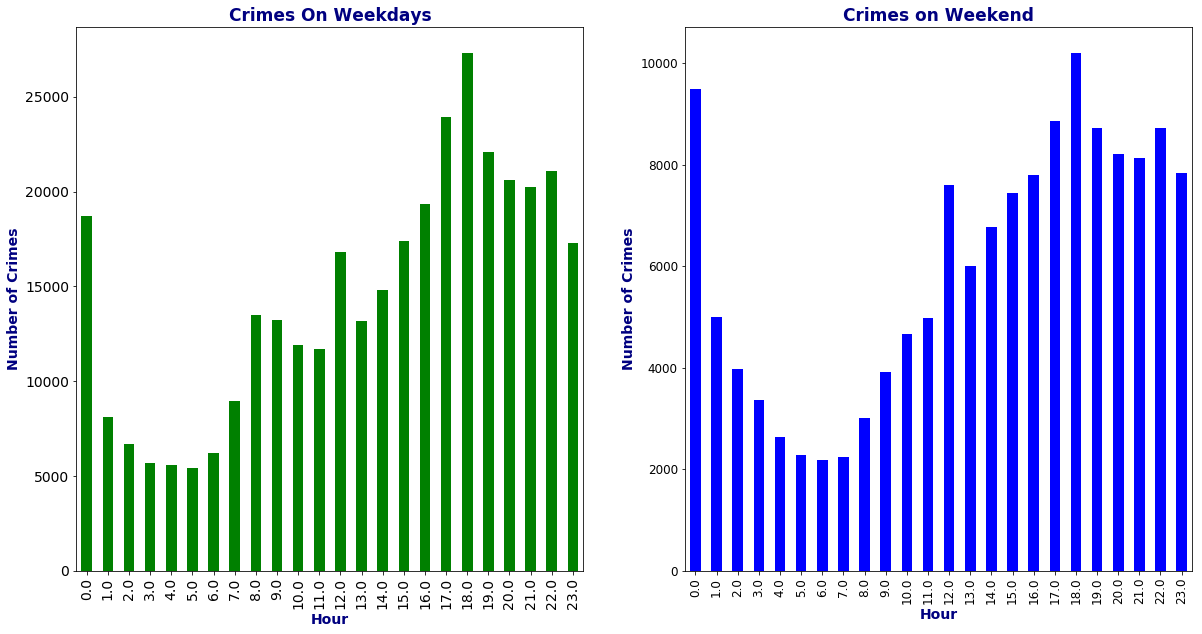

In [19]:
plt.figure(figsize = (20,10))
plt.style.use('seaborn-pastel')

df99 = df[df.HOUR != 99]
plt.subplot(1,2,1)
df99[(df99.DAY_OF_WEEK < 5)].groupby('HOUR').size().plot(kind='bar', fontsize=14, color='GREEN')
plt.xlabel('Hour', fontsize=14, weight='bold', color='navy')
plt.ylabel('Number of Crimes', fontsize=14, weight='bold', color='navy')
plt.title('Crimes On Weekdays', fontsize=17, weight='bold', color='navy')

plt.subplot(1,2,2)
df99[(df99.DAY_OF_WEEK >= 5)].groupby('HOUR').size().plot(kind='bar', fontsize=14, color='BLUE')
plt.tick_params(labelsize=12)
plt.ylabel('Number of Crimes', fontsize=14, weight='bold', color='navy')
plt.xlabel('Hour', fontsize=14, weight='bold', color='navy')
plt.title('Crimes on Weekend', fontsize=17, weight='bold', color='navy')


plt.show()

##### Indeed, we see that the highest number of crimes committed is in the evening around **5pm-7pm** regardless whether it is on weekend or weekdays

## Where are crimes being committed in Vancouver?

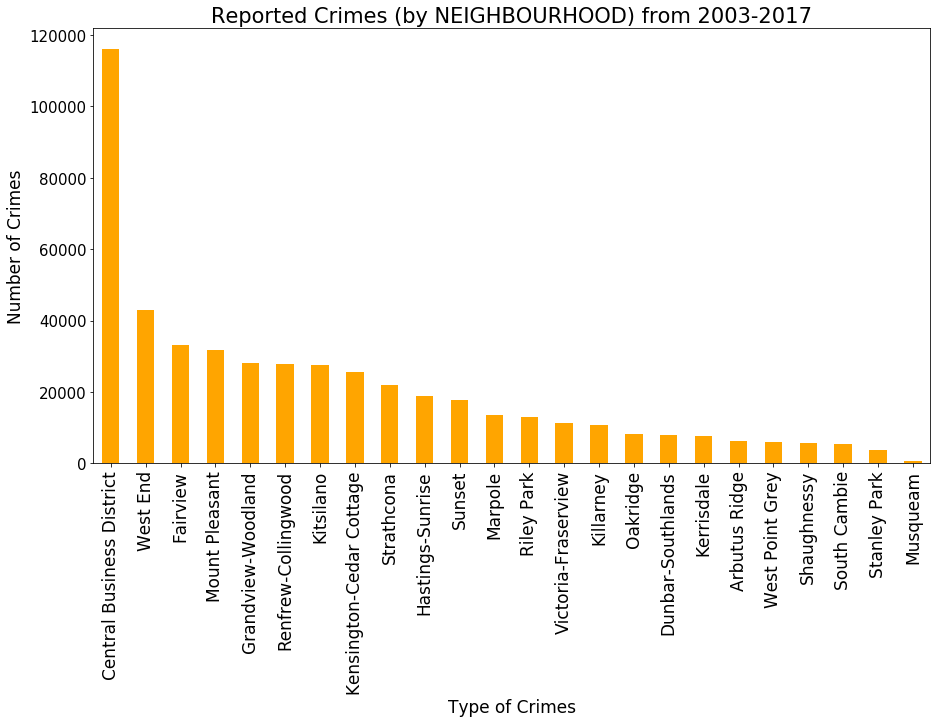

In [20]:
dfND = df[df.NEIGHBOURHOOD != 'N/A'] #Exclude crimes with missing NEIGHBOURHOOD values.
df_plt2 = dfND.groupby('NEIGHBOURHOOD').size().sort_values(ascending=False)
plt.style.use('seaborn-pastel')

#labels_list = df_plt2.values
#wargs = {'fontsize': 14, 'ha':'center', 'va': 'bottom', 'weight': 'bold', 'color': 'navy'}

ax = df_plt2.plot(kind='bar', figsize=(15,8),color='Orange')

#annotate_labels(ax, labels_list, **kwargs)

plt.title('Reported Crimes (by NEIGHBOURHOOD) from 2003-2017', fontsize=21)
plt.ylabel('Number of Crimes', fontsize=17)
plt.xlabel('Type of Crimes', fontsize=17)
plt.xticks(size = 17)
plt.yticks(size = 15)


plt.show()

##### We see that most crimes are committed in the downtown area followed by the West End area. 

## Let's see the distribution of crimes per day

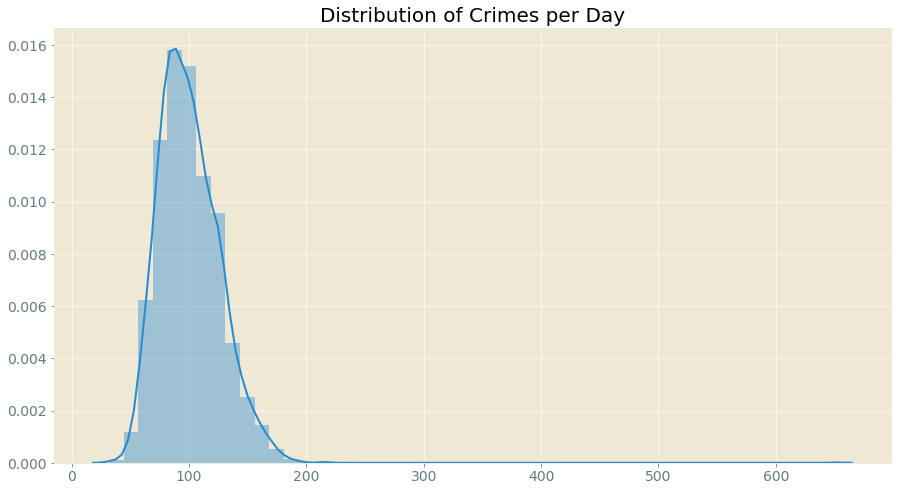

In [21]:
plt.figure(figsize=(15,8))
plt.style.use('Solarize_Light2')
plt.title('Distribution of Crimes per Day', fontsize=20)
plt.tick_params(labelsize=14)
sns.distplot(df.resample('D').size()); #resample('D') groups it by day and size

#### From the distribution above, there are clearly some outliers in the data. 

### Outlier

In [22]:
df.resample('D').size().idxmax()

Timestamp('2011-06-15 00:00:00', freq='D')

#### Let's attempt to see what happened during that day

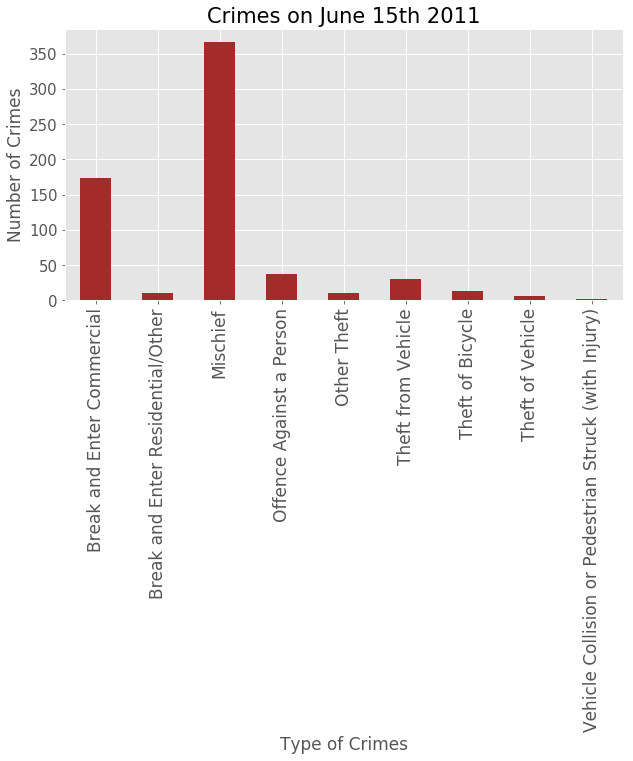

In [23]:
plt.style.use('ggplot')
plt.figure(figsize = (10,5))

df[df['DATE']=='2011-06-15'].groupby('TYPE').size().plot(kind='bar',color='Brown')



plt.title('Crimes on June 15th 2011', fontsize=21)
plt.ylabel('Number of Crimes', fontsize=17)
plt.xlabel('Type of Crimes', fontsize=17)
plt.xticks(size = 17)
plt.yticks(size = 15)

plt.show()

### With some research, it was the [Stanley cup riot](https://en.wikipedia.org/wiki/2011_Vancouver_Stanley_Cup_riot) ! 

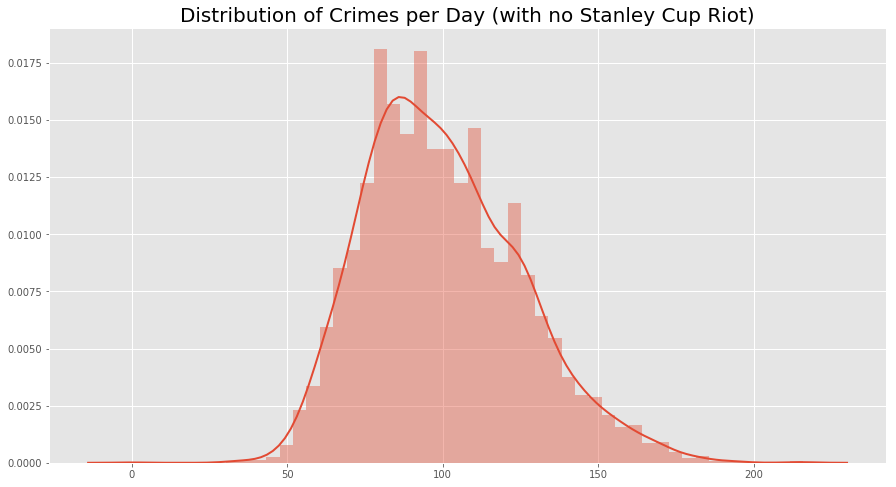

In [24]:
#Now, let's replot the distribution once we remove that significant day.
plt.figure(figsize=(15,8))
plt.title('Distribution of Crimes per Day (with no Stanley Cup Riot)', fontsize=20)


sns.distplot(df[df['DATE'] != '2011-06-15'].resample('D').size());

plt.show()

### Now, let's attempt to create a heatmap to see the average number of crimes per day and month over the 15 year period. 

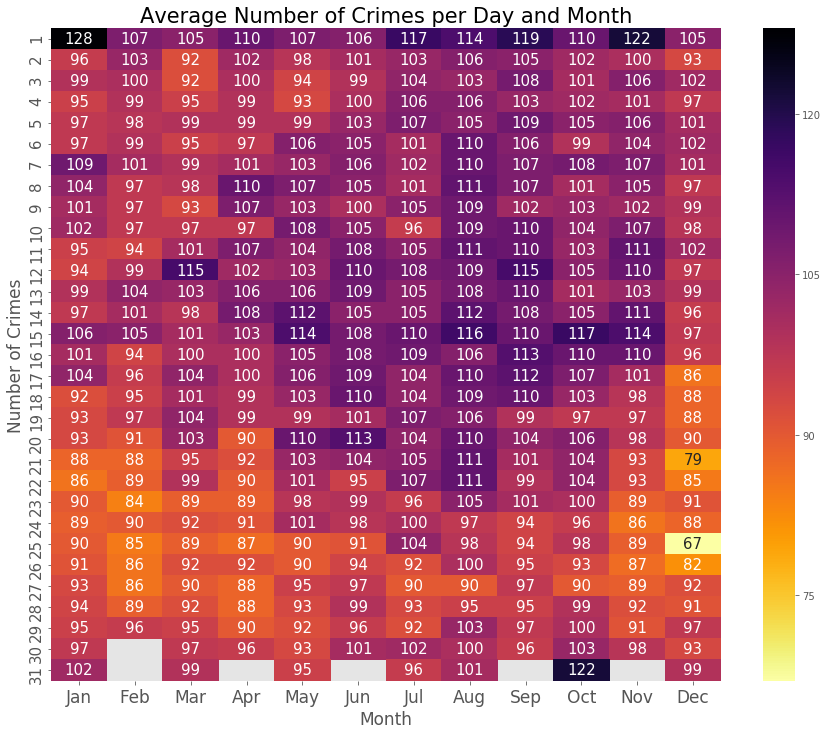

In [25]:
dfSCR = df[df['DATE'] != '2011-06-15'] #let's exclude the Stanley Cup Riot Day
df_pivtab = dfSCR.pivot_table(values='TYPE', index='DAY', columns='MONTH', aggfunc=len)
df_pivtab_year_count= dfSCR.pivot_table(values='YEAR', index='DAY', columns='MONTH', aggfunc=lambda x: len(x.unique()))
avg_crime = df_pivtab/df_pivtab_year_count
avg_crime.columns = month_labels

plt.figure(figsize=(15,12))
ax=sns.heatmap(avg_crime.round(), annot=True, fmt=".0f",cmap='inferno_r',annot_kws={"size": 15});

plt.title('Average Number of Crimes per Day and Month', fontsize=21)
plt.ylabel('Number of Crimes', fontsize=17)
plt.xlabel('Month', fontsize=17)
plt.xticks(size = 17)
plt.yticks(size = 15)

plt.show()


### What does the crime trend look like over the years?

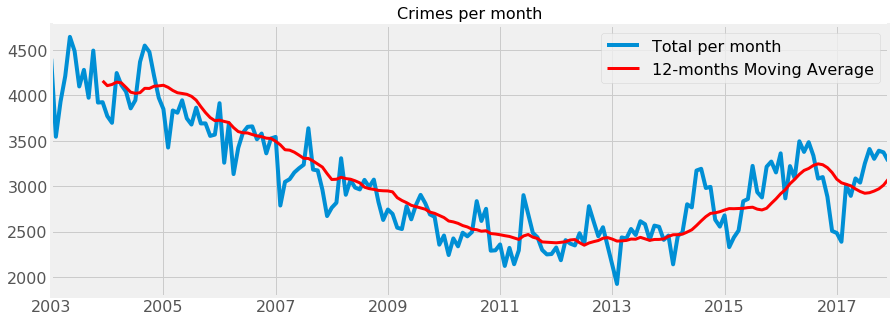

In [26]:
plt.figure(figsize=(15,5))
plt.style.use('fivethirtyeight')
df.resample('M').size().plot(label='Total per month')
df.resample('M').size().rolling(window=12).mean().plot(color='red', linewidth=3, label='12-months Moving Average')

plt.title('Crimes per month', fontsize=16)
plt.xlabel('')
plt.legend(prop={'size':16})
plt.tick_params(labelsize=16)

plt.show()

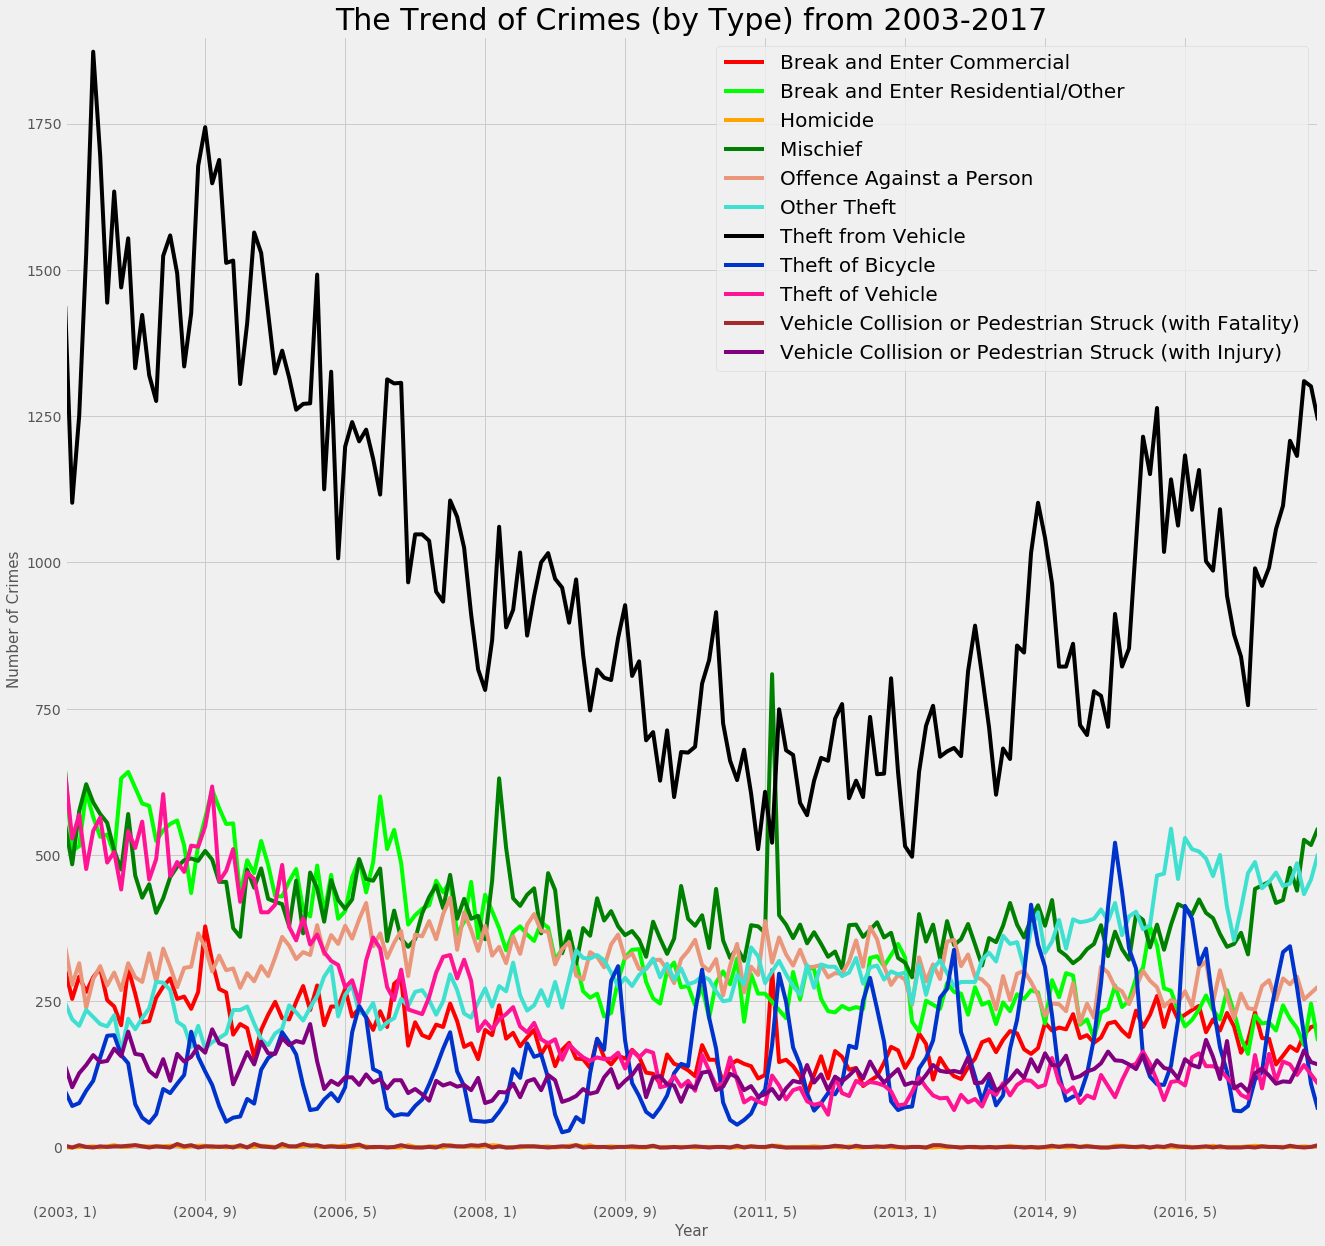

In [27]:
df.groupby(['YEAR','MONTH','TYPE'])['TYPE'].count().unstack().fillna(0).plot(figsize=(20,20),
color=['r','#00ff00','orange','g','darksalmon','turquoise','k','#0033cc','deeppink','brown',
       'purple']);

plt.legend(loc=1,prop={'size':20})
plt.xlabel('Year',size=15)
plt.ylabel('Number of Crimes', size=15)
plt.title('The Trend of Crimes (by Type) from 2003-2017', size=30)
plt.ylim(ymax=1900)


plt.show()

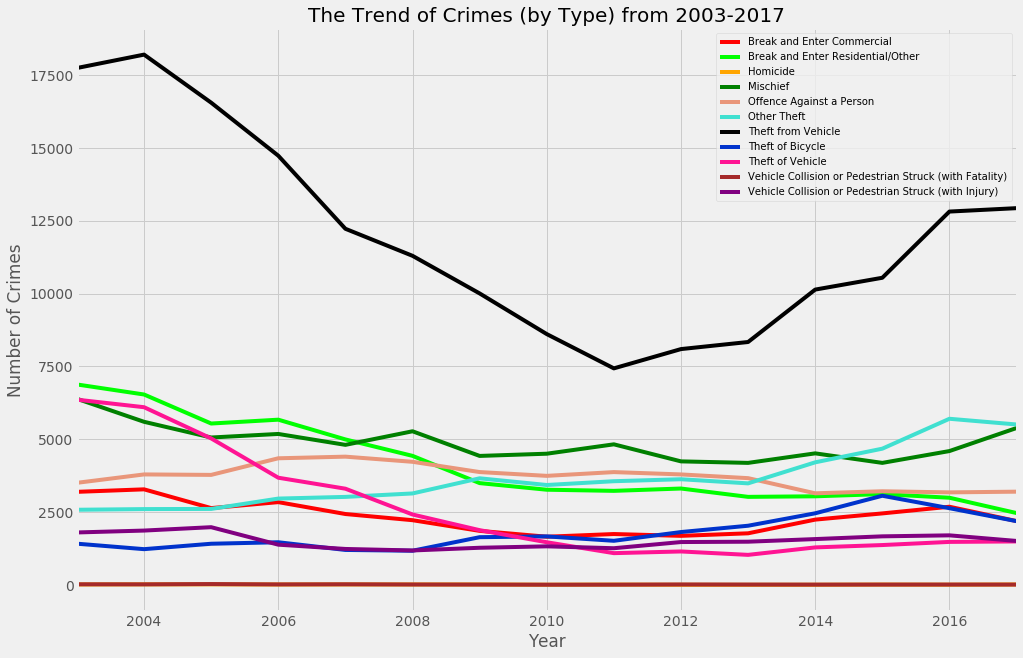

In [28]:
plt.style.use('seaborn-pastel')

df_plt2 = df.groupby(['YEAR','TYPE'])['YEAR'].count().unstack().fillna(0)
df_plt2.plot(color=['r','#00ff00','orange','g','darksalmon',
                'turquoise','k','#0033cc','deeppink','brown','purple'],figsize=(15,10))

plt.legend(loc=1,prop={'size':10})
plt.grid(True)
plt.ylabel('Number of Crimes')
plt.xlabel('Year')
plt.title('The Trend of Crimes (by Type) from 2003-2017', size=20)


plt.show()

In [29]:
df.TYPE.unique()

array(['Theft from Vehicle', 'Offence Against a Person',
       'Break and Enter Commercial', 'Mischief',
       'Break and Enter Residential/Other', 'Theft of Bicycle',
       'Theft of Vehicle',
       'Vehicle Collision or Pedestrian Struck (with Fatality)',
       'Vehicle Collision or Pedestrian Struck (with Injury)',
       'Other Theft', 'Homicide'], dtype=object)

### Perhaps we can break down the different kind of crimes into smaller categories

In [30]:
def category(crime_type):
    if 'Theft' in crime_type:
        return 'Theft'
    elif 'Break' in crime_type:
        return 'Break and Enter'
    elif 'Collision' in crime_type:
        return 'Vehicle Collision'
    else:
        return 'Homicide, Mischief and Others'

In [31]:
df['CATEGORY'] = df['TYPE'].apply(category)

In [32]:
import warnings
warnings.filterwarnings("ignore")

### Trend of crimes from 2003 to 2017

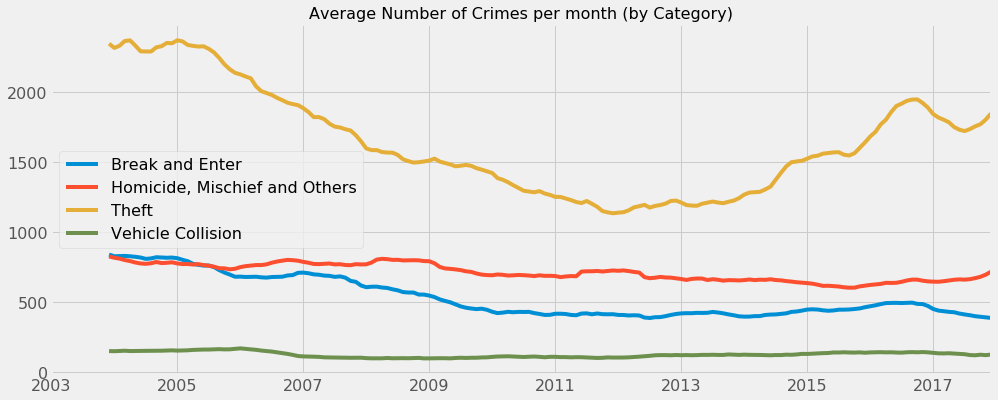

In [33]:
plt.style.use('fivethirtyeight')
df.pivot_table(values='TYPE', index='DATE', columns='CATEGORY', aggfunc=len).resample('M').sum().rolling(window=12).mean().plot(figsize=(15,6), linewidth=4)
plt.title('Average Number of Crimes per month (by Category)', fontsize=16)
plt.xlabel('')
plt.legend(prop={'size':16})
plt.tick_params(labelsize=16);

In [34]:
category_label = ['Break and Enter','Homicide, Mischief and Others','Theft','Vehicle Collision']

### Relationship between the frequency of crimes over a given year

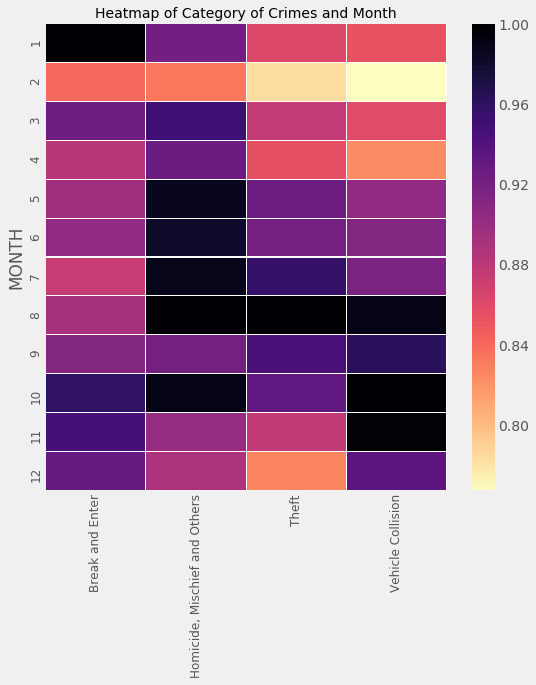

In [35]:
plt.figure(figsize=(8,8))

df_plt3 = df.pivot_table(values='TYPE', index='CATEGORY', columns='MONTH', aggfunc=len)

df_plt3_scaled = pd.DataFrame(df_plt3.iloc[0] / df_plt3.iloc[0].max())

# To compare categories, scale each category by dividing the max val of each one.
for i in range(1,4):
    df_plt3_scaled[df_plt3_scaled.index[i]] = pd.DataFrame(df_plt3.iloc[i] / df_plt3.iloc[i].max())


df_plt3_scaled.columns = category_label
plt.title('Heatmap of Category of Crimes and Month', fontsize=14)
plt.tick_params(labelsize=12)


sns.heatmap(df_plt3_scaled, cmap='magma_r',linewidths=0.1)

plt.show()

### Relationship between the frequency of crimes over a given week

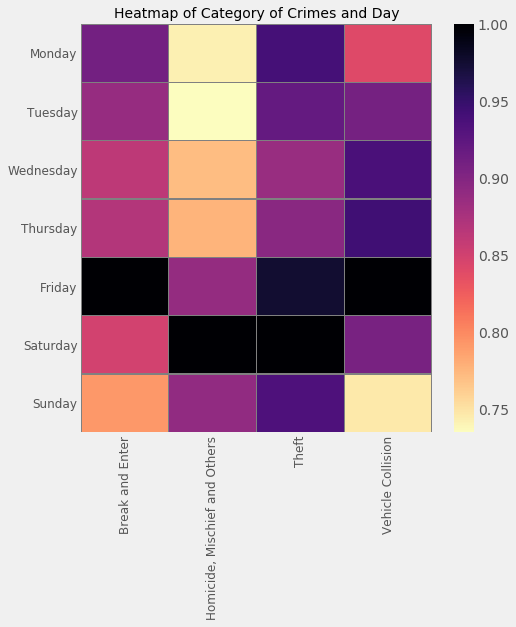

In [36]:
plt.figure(figsize=(7,7))

df_plt4 = df.pivot_table(values='TYPE', index='CATEGORY', columns='DAY_OF_WEEK', aggfunc=len)

# To compare categories, I'm scaling each category by diving by the max value of each one
df_plt4_scaled = pd.DataFrame(df_plt4.iloc[0] / df_plt4.iloc[0].max())

# Scale each category by dividing the max val of each one to compare categories
for i in range(1,4):
    df_plt4_scaled[df_plt4_scaled.index[i]] =  pd.DataFrame(df_plt4.iloc[i] / df_plt4.iloc[i].max())

df_plt4_scaled.index = weekday_labels
df_plt4_scaled.columns = category_label
plt.title('Heatmap of Category of Crimes and Day', fontsize=14)
plt.tick_params(labelsize=12)

sns.heatmap(df_plt4_scaled, cmap='magma_r', linecolor='grey',linewidths=0.1);

### Plotting X, Y coordinates of crimes happening around Vancouver in year 2003 and 2017

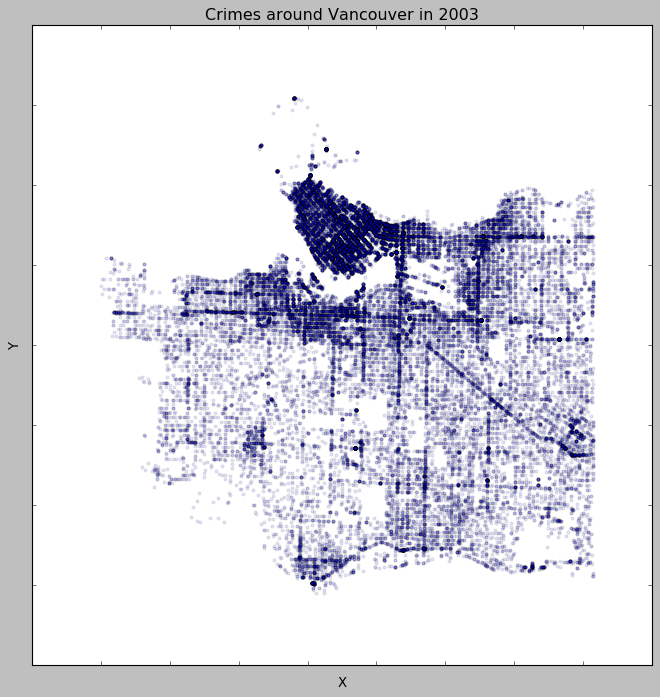

In [37]:
plt.style.use('classic')

ax=df[(df['X'] != 0) & (df['YEAR']==2003)].plot(kind='scatter',x='X',y='Y',alpha=0.1, figsize=(10,10),s=7)

ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_title('Crimes around Vancouver in 2003')

plt.show()

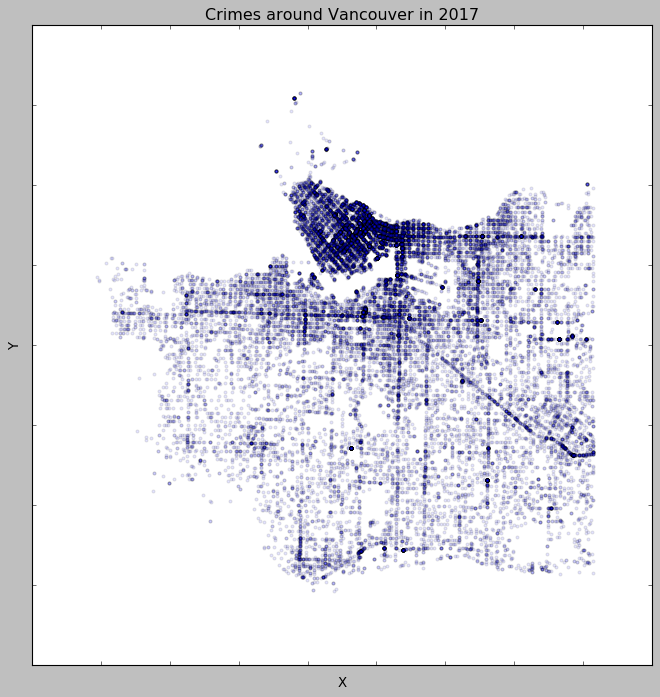

In [38]:
ax2=df[(df['X'] != 0) & (df['YEAR']==2017)].plot(kind='scatter',x='X',y='Y',alpha=0.1, figsize=(10,10),s=7)

ax2.set_xticklabels([])
ax2.set_yticklabels([])
ax2.set_title('Crimes around Vancouver in 2017')

plt.show()